# **Load ChEMBL data**

In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('raw_CHEMBL1957_IGF1R.csv',sep=";")
print(df.shape)
df.head(3)

(4380, 45)


,Molecule ChEMBL ID,Molecule Name,Molecule Max Phase,Molecular Weight,#RO5 Violations,AlogP,Compound Key,Smiles,Standard Type,Standard Relation,Standard Value,Standard Units,pChEMBL Value,Data Validity Comment,Comment,Uo Units,Ligand Efficiency BEI,Ligand Efficiency LE,Ligand Efficiency LLE,Ligand Efficiency SEI,Potential Duplicate,Assay ChEMBL ID,Assay Description,Assay Type,BAO Format ID,BAO Label,Assay Organism,Assay Tissue ChEMBL ID,Assay Tissue Name,Assay Cell Type,Assay Subcellular Fraction,Assay Parameters,Assay Variant Accession,Assay Variant Mutation,Target ChEMBL ID,Target Name,Target Organism,Target Type,Document ChEMBL ID,Source ID,Source Description,Document Journal,Document Year,Cell ChEMBL ID,Properties
0,CHEMBL3980637,NaN,0,564.65,2,2.77,BDBM184393,Cn1cc(-c2cccc(Cc3c4c(nn3C)CCc3cnc(Nc5ccn(CC(=O...,IC50,'=',1.0,nM,9.0,NaN,332668,UO_0000065,15.94,0.29,6.23,7.45,False,CHEMBL3887328,DELFIA Assay: The kinase activity is measured ...,B,BAO_0000357,single protein format,None,None,None,None,None,NaN,NaN,NaN,CHEMBL1957,Insulin-like growth factor I receptor,Homo sapiens,SINGLE PROTEIN,CHEMBL3886278,37,BindingDB Database,NaN,2015.0,None,NaN
1,CHEMBL259394,NaN,0,451.43,1,5.97,1,COc1cc2nccc(Oc3ccc(NC(=O)Nc4ccc(F)cc4)cc3F)c2c...,IC50,'>',2000.0,nM,NaN,NaN,NaN,UO_0000065,NaN,NaN,NaN,NaN,False,CHEMBL923904,Inhibition of IGF1R by ELISA,B,BAO_0000357,single protein format,None,None,None,None,None,NaN,NaN,NaN,CHEMBL1957,Insulin-like growth factor I receptor,Homo sapiens,SINGLE PROTEIN,CHEMBL1144754,1,Scientific Literature,Bioorg. Med. Chem.,2008.0,None,NaN
2,CHEMBL3660972,NaN,0,607.76,2,5.08,BDBM122916,COc1cc(C(=O)NC2CCN(C3CCOCC3)CC2)ccc1Nc1ncc2c(n...,IC50,'=',4.0,nM,8.4,NaN,251707,UO_0000065,13.82,0.25,3.32,7.89,False,CHEMBL3705323,DELFIA assay: The kinase activity is measured ...,B,BAO_0000357,single protein format,Homo sapiens,None,None,None,None,NaN,NaN,NaN,CHEMBL1957,Insulin-like growth factor I receptor,Homo sapiens,SINGLE PROTEIN,CHEMBL3639315,37,BindingDB Database,NaN,2014.0,None,NaN


In [3]:
print(df.columns)

Index(['Molecule ChEMBL ID', 'Molecule Name', 'Molecule Max Phase',
       'Molecular Weight', '#RO5 Violations', 'AlogP', 'Compound Key',
       'Smiles', 'Standard Type', 'Standard Relation', 'Standard Value',
       'Standard Units', 'pChEMBL Value', 'Data Validity Comment', 'Comment',
       'Uo Units', 'Ligand Efficiency BEI', 'Ligand Efficiency LE',
       'Ligand Efficiency LLE', 'Ligand Efficiency SEI', 'Potential Duplicate',
       'Assay ChEMBL ID', 'Assay Description', 'Assay Type', 'BAO Format ID',
       'BAO Label', 'Assay Organism', 'Assay Tissue ChEMBL ID',
       'Assay Tissue Name', 'Assay Cell Type', 'Assay Subcellular Fraction',
       'Assay Parameters', 'Assay Variant Accession', 'Assay Variant Mutation',
       'Target ChEMBL ID', 'Target Name', 'Target Organism', 'Target Type',
       'Document ChEMBL ID', 'Source ID', 'Source Description',
       'Document Journal', 'Document Year', 'Cell ChEMBL ID', 'Properties'],
      dtype='object')


## **Filter data by standard units**

In [5]:
# Check if the data only has target_organism=='Homo sapiens'
print(pd.unique(df['Target Organism']))
# Filter data by target_organism=='Homo sapiens'
df=df[df['Target Organism'].isin(['Homo sapiens'])]
print(pd.unique(df['Target Organism']))
print(df.shape)

# Check if the data only has standard_type=='IC50'
print(pd.unique(df['Standard Type']))

print(pd.unique(df['Standard Units']))
# Filter data by units = ['nM','ug.mL-1','uM','pM','ug/g']
units = ['nM','ug.mL-1','uM','pM','ug/g']
df=df[df['Standard Units'].isin(units)].reset_index().drop(columns='index')

print(pd.unique(df['Standard Units']))
print(df.shape)

['Homo sapiens']
['Homo sapiens']
(4341, 45)
['IC50']
['nM' 'ug.mL-1']
['nM' 'ug.mL-1']
(4341, 45)


# **Data Cleaning**


* Drop missing SMILE notation
* Drop missing standard values
* Drop duplicated assays (by assay ID)


In [6]:
# Drop compounds having missing standard_value.
df2 = df[df['Standard Value'].notna()]
print(df2.shape)

# Drop compounds having missing canonical_smiles column.
df2 = df2[df['Smiles'].notna()]
print(df2.shape)

# Reset index
df2 = df2.reset_index().drop(columns='index')
print(df2.shape)
df2.head(3)

(4341, 45)
(4341, 45)
(4341, 45)


,Molecule ChEMBL ID,Molecule Name,Molecule Max Phase,Molecular Weight,#RO5 Violations,AlogP,Compound Key,Smiles,Standard Type,Standard Relation,Standard Value,Standard Units,pChEMBL Value,Data Validity Comment,Comment,Uo Units,Ligand Efficiency BEI,Ligand Efficiency LE,Ligand Efficiency LLE,Ligand Efficiency SEI,Potential Duplicate,Assay ChEMBL ID,Assay Description,Assay Type,BAO Format ID,BAO Label,Assay Organism,Assay Tissue ChEMBL ID,Assay Tissue Name,Assay Cell Type,Assay Subcellular Fraction,Assay Parameters,Assay Variant Accession,Assay Variant Mutation,Target ChEMBL ID,Target Name,Target Organism,Target Type,Document ChEMBL ID,Source ID,Source Description,Document Journal,Document Year,Cell ChEMBL ID,Properties
0,CHEMBL3980637,NaN,0,564.65,2,2.77,BDBM184393,Cn1cc(-c2cccc(Cc3c4c(nn3C)CCc3cnc(Nc5ccn(CC(=O...,IC50,'=',1.0,nM,9.0,NaN,332668,UO_0000065,15.94,0.29,6.23,7.45,False,CHEMBL3887328,DELFIA Assay: The kinase activity is measured ...,B,BAO_0000357,single protein format,None,None,None,None,None,NaN,NaN,NaN,CHEMBL1957,Insulin-like growth factor I receptor,Homo sapiens,SINGLE PROTEIN,CHEMBL3886278,37,BindingDB Database,NaN,2015.0,None,NaN
1,CHEMBL259394,NaN,0,451.43,1,5.97,1,COc1cc2nccc(Oc3ccc(NC(=O)Nc4ccc(F)cc4)cc3F)c2c...,IC50,'>',2000.0,nM,NaN,NaN,NaN,UO_0000065,NaN,NaN,NaN,NaN,False,CHEMBL923904,Inhibition of IGF1R by ELISA,B,BAO_0000357,single protein format,None,None,None,None,None,NaN,NaN,NaN,CHEMBL1957,Insulin-like growth factor I receptor,Homo sapiens,SINGLE PROTEIN,CHEMBL1144754,1,Scientific Literature,Bioorg. Med. Chem.,2008.0,None,NaN
2,CHEMBL3660972,NaN,0,607.76,2,5.08,BDBM122916,COc1cc(C(=O)NC2CCN(C3CCOCC3)CC2)ccc1Nc1ncc2c(n...,IC50,'=',4.0,nM,8.4,NaN,251707,UO_0000065,13.82,0.25,3.32,7.89,False,CHEMBL3705323,DELFIA assay: The kinase activity is measured ...,B,BAO_0000357,single protein format,Homo sapiens,None,None,None,None,NaN,NaN,NaN,CHEMBL1957,Insulin-like growth factor I receptor,Homo sapiens,SINGLE PROTEIN,CHEMBL3639315,37,BindingDB Database,NaN,2014.0,None,NaN


## **Convert Standard Units**

In [7]:
df2 = df2.sort_values('Standard Value').reset_index().drop(columns='index')
df2[['Standard Units','Standard Value','Molecular Weight']].tail(5)

,Standard Units,Standard Value,Molecular Weight
4336,nM,1000000.0,368.23
4337,nM,1000000.0,262.27
4338,nM,2900000.0,499.62
4339,nM,20000000.0,451.60
4340,nM,22000000.0,451.55


In [8]:
#units = ['nM','ug.mL-1','uM','pM','ug/g']

standard_unit_nM = []

for i,j,k in zip(df2['Standard Units'],df2['Standard Value'],df2['Molecular Weight']):
    if i == 'nM':
      standard_unit_nM.append(float(j))
    elif i == 'ug.mL-1':
      standard_unit_nM.append(float(1000000*float(j)/float(k)))
    elif i == 'uM':
      standard_unit_nM.append(float(1000*float(j)))
    elif i == 'pM':
      standard_unit_nM.append(float(float(j)/1000))
    elif i == 'ug/g':
      standard_unit_nM.append(float(1000000*float(j)/float(k)))

In [9]:
#standard_unit_nM
standard_value_nM = pd.Series(standard_unit_nM, name='standard_value_nM')

print(standard_value_nM.shape)
standard_value_nM.tail(3)

(4341,)


4338     2900000.0
4339    20000000.0
4340    22000000.0
Name: standard_value_nM, dtype: float64

In [10]:
df3 = pd.concat([df2, standard_value_nM], axis=1)
#df3.columns
#df3[['Standard Value','Standard Units','standard_unit_nM']]

print(standard_value_nM.shape)
print(df2.shape)
print(df3.shape)

# Sort data by ascending 'standard_unit_nM' values.
df3 = df3.sort_values('standard_value_nM',ascending=True).reset_index().drop(columns='index')
df3[['Standard Value','Standard Units','standard_value_nM', 'Molecular Weight']].loc[(df3['Standard Units']=='ug.mL-1')].tail(2)

(4341,)
(4341, 45)
(4341, 46)


,Standard Value,Standard Units,standard_value_nM,Molecular Weight
4192,10.0,ug.mL-1,35177.823900,284.27
4193,10.0,ug.mL-1,36200.405445,276.24


## **Duplicated Compounds**

In [11]:
# Keep the one with minimum standard_value for duplicated ['compound_ID','target_ID']
df3 = df3.drop_duplicates(subset=['Molecule ChEMBL ID','Target ChEMBL ID'], keep='first').reset_index().drop(columns='index')
print(df3.shape)
df3['standard_value_nM']

(2929, 46)


0              0.05
1              0.05
2              0.08
3              0.08
4              0.08
           ...     
2924     1000000.00
2925     1000000.00
2926     2900000.00
2927    20000000.00
2928    22000000.00
Name: standard_value_nM, Length: 2929, dtype: float64

In [12]:
# Data pre-processing
# Combine columns (molecule_chembl_id,canonical_smiles,standard_value) and bioactivity_class into a DataFrame
selection = ['Molecule ChEMBL ID','Smiles','standard_value_nM']
df4 = df3[selection].rename(columns={'Molecule ChEMBL ID':'molecule_chembl_id','Smiles':'canonical_smiles','standard_unit_nM':'standard_value'})
print(df4.shape)
df4.head(3)

(2929, 3)


,molecule_chembl_id,canonical_smiles,standard_value_nM
0,CHEMBL3905758,CN1CCN(CCn2ccc(Nc3ncc4c(n3)-c3c(nn(C)c3-c3ccc(...,0.05
1,CHEMBL3950012,COc1cc(N2CCN(C(C)C)CC2)ccc1Nc1ncc2c(n1)-c1c(nn...,0.05
2,CHEMBL3955626,COc1cc(N2CCN(CCO)CC2)ccc1Nc1ncc2c(n1)-c1c(nn(C...,0.08


In [13]:
# Saves to CSV 
df4.to_csv('CHEMBL1957_bioactivity_data_preprocessed.csv', index=False)

# **Labeling** 

In [14]:
import pandas as pd

df5 = pd.read_csv('CHEMBL1957_bioactivity_data_preprocessed.csv')
df5.head(3)

,molecule_chembl_id,canonical_smiles,standard_value_nM
0,CHEMBL3905758,CN1CCN(CCn2ccc(Nc3ncc4c(n3)-c3c(nn(C)c3-c3ccc(...,0.05
1,CHEMBL3950012,COc1cc(N2CCN(C(C)C)CC2)ccc1Nc1ncc2c(n1)-c1c(nn...,0.05
2,CHEMBL3955626,COc1cc(N2CCN(CCO)CC2)ccc1Nc1ncc2c(n1)-c1c(nn(C...,0.08


### Distribution


In [15]:
import seaborn as sns
import numpy as np
sns.set(style='ticks')
import matplotlib.pyplot as plt

In [16]:
#df5.standard_value_nM.describe()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


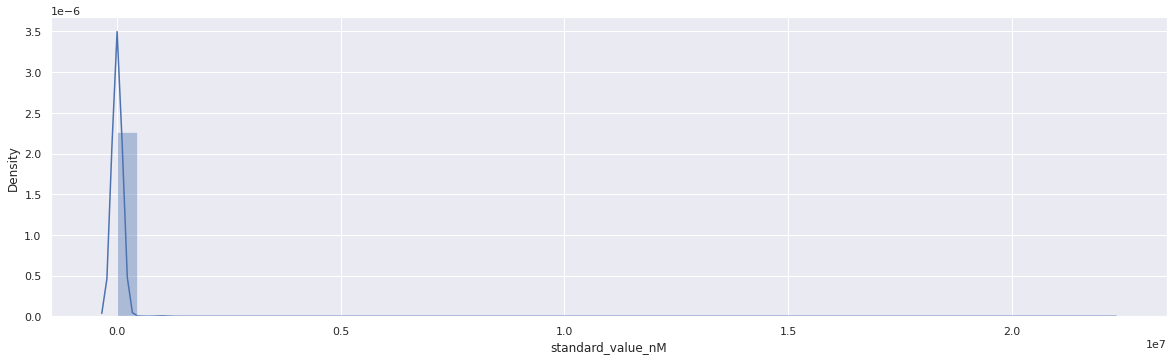

In [17]:
#skewed standard_value distribution
plt.figure(figsize=(20,5.5))
sns.set_theme(); 
ax=sns.distplot(df5['standard_value_nM'])

### Scaling (pIC50)


To allow **IC50** data to be more uniformly distributed, we will convert **IC50** to the negative logarithmic scale which is essentially **-log10(IC50)**.

This custom function pIC50() will accept a DataFrame as input and will:
* Take the IC50 values from the ``standard_value`` column and converts it from nM to M by multiplying the value by 10$^{-9}$
* Take the molar value and apply -log10
* Delete the ``standard_value`` column and create a new ``pIC50`` column

In [18]:
import numpy as np

def pIC50(input):
    pIC50 = []

    for i in input['standard_value_norm']:
        molar = i*(10**-9) # Converts nM to M
        pIC50.append(-np.log10(molar))

    input['pIC50'] = pIC50
    x = input.drop('standard_value_norm', 1)
        
    return x

In [19]:
def norm_value(input):
    norm = []

    for i in input['standard_value_nM']:
        #  Values greater than 100,000,000 will be fixed at 100,000,000 otherwise the negative logarithmic value will become negative.
        if i > 100000000:
          i = 100000000
        norm.append(i)

    input['standard_value_norm'] = norm
    x = input.drop('standard_value_nM', 1)
        
    return x

In [20]:
# Normalization
df6 = norm_value(df5)
df_norm = pIC50(df6)
df_norm.head #.pIC50.describe()

<bound method NDFrame.head of      molecule_chembl_id  ...      pIC50
0         CHEMBL3905758  ...  10.301030
1         CHEMBL3950012  ...  10.301030
2         CHEMBL3955626  ...  10.096910
3         CHEMBL3928243  ...  10.096910
4         CHEMBL3977170  ...  10.096910
...                 ...  ...        ...
2924      CHEMBL4213021  ...   3.000000
2925      CHEMBL1276127  ...   3.000000
2926      CHEMBL3353410  ...   2.537602
2927      CHEMBL1956069  ...   1.698970
2928      CHEMBL1956070  ...   1.657577

[2929 rows x 3 columns]>

In [21]:
#df_norm.pIC50.describe()

#### **Distribution plots**

In [22]:
botton_line = np.percentile(df_norm.pIC50, 20)
top_line = np.percentile(df_norm.pIC50, 80)
top_line
botton_line

5.411671326906953

In [23]:
'''plt.figure(figsize=(16, 4))

sns.set_theme(); 

ax = sns.distplot(df_norm['pIC50'], hist=True, color='#388E3C')
kde_x, kde_y = ax.lines[0].get_data()

#plotting the two lines
p1 = plt.axvline(x=botton_line,color='#EF9A9A')
p2 = plt.axvline(x=top_line,color='#EF9A9A')

ax.fill_between(kde_x, kde_y, where=(kde_x<botton_line) | (kde_x>top_line) , 
                interpolate=True, color='#EF9A9A')'''

"plt.figure(figsize=(16, 4))\n\nsns.set_theme(); \n\nax = sns.distplot(df_norm['pIC50'], hist=True, color='#388E3C')\nkde_x, kde_y = ax.lines[0].get_data()\n\n#plotting the two lines\np1 = plt.axvline(x=botton_line,color='#EF9A9A')\np2 = plt.axvline(x=top_line,color='#EF9A9A')\n\nax.fill_between(kde_x, kde_y, where=(kde_x<botton_line) | (kde_x>top_line) , \n                interpolate=True, color='#EF9A9A')"

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


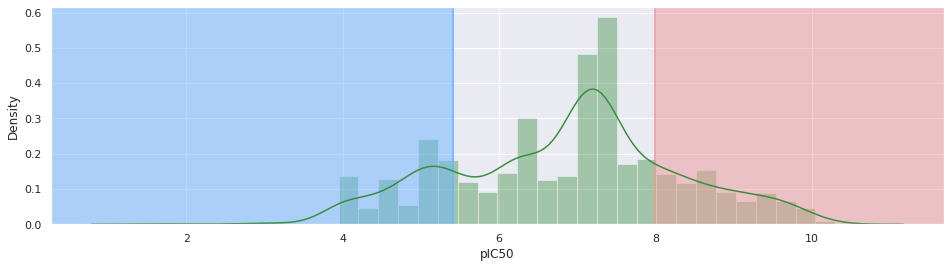

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(16,4))

#plotting the two lines
p1 = plt.axvline(x=botton_line,color='#6DB6FF')
p2 = plt.axvline(x=top_line,color='#EF9A9A')

#plotting the PDF
ax = sns.distplot(df_norm['pIC50'], hist=True, color='#388E3C')

xlim = ax.get_xlim()
ax.axvspan(xlim[0], botton_line, color='#6DB6FF', alpha=0.5)
ax.axvspan(top_line, xlim[1], color='#EF9A9A', alpha=0.5)
#reset xlim
ax.set_xlim(xlim)
plt.show()

## **Labeling**

In [25]:
bioactivity_threshold = []
for i in df_norm.pIC50:
  if float(i) >= top_line:
    bioactivity_threshold.append("active")
  elif float(i) <= botton_line:
    bioactivity_threshold.append("inactive")
  else:
    bioactivity_threshold.append("intermediate")

In [26]:
# Combine the data
bioactivity_class = pd.Series(bioactivity_threshold, name='bioactivity_class')
df7 = pd.concat([df_norm,bioactivity_class],axis=1)
print(df7.shape)
df7.head(3)

(2929, 4)


,molecule_chembl_id,canonical_smiles,pIC50,bioactivity_class
0,CHEMBL3905758,CN1CCN(CCn2ccc(Nc3ncc4c(n3)-c3c(nn(C)c3-c3ccc(...,10.30103,active
1,CHEMBL3950012,COc1cc(N2CCN(C(C)C)CC2)ccc1Nc1ncc2c(n1)-c1c(nn...,10.30103,active
2,CHEMBL3955626,COc1cc(N2CCN(CCO)CC2)ccc1Nc1ncc2c(n1)-c1c(nn(C...,10.09691,active


In [27]:
print(
    ' active',df7['bioactivity_class'][df7['bioactivity_class']=="active"].count(),'\n',
    'inactive',df7['bioactivity_class'][df7['bioactivity_class']=="inactive"].count(),'\n',
    'intermediate',df7['bioactivity_class'][df7['bioactivity_class']=="intermediate"].count()
)

 active 610 
 inactive 586 
 intermediate 1733


Saves dataframe to CSV file

In [28]:
df7.to_csv('CHEMBL1957_bioactivity_data_curated.csv', index=False)

# **Removing 'intermediate' class**

In [30]:
df_2class = df7[df7['bioactivity_class'] != 'intermediate']
df_2class.shape

(1196, 4)

In [31]:
df_2class.to_csv('CHEMBL1957_2classes_data.csv', index=False)

# **Exporatory Data Analysis**

## **Install conda and rdkit**

In [32]:
# Install conda and rdkit
! wget https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.2-Linux-x86_64.sh
! chmod +x Miniconda3-py37_4.8.2-Linux-x86_64.sh
! bash ./Miniconda3-py37_4.8.2-Linux-x86_64.sh -b -f -p /usr/local
! conda install -c rdkit rdkit -y
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')

--2021-04-08 18:19:55--  https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.2-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.130.3, 104.16.131.3, 2606:4700::6810:8303, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.130.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 85055499 (81M) [application/x-sh]
Saving to: ‘Miniconda3-py37_4.8.2-Linux-x86_64.sh’

Miniconda3-py37_4.8 100%[===================>]  81.12M  4.09MB/s    in 21s     

2021-04-08 18:20:16 (3.94 MB/s) - ‘Miniconda3-py37_4.8.2-Linux-x86_64.sh’ saved [85055499/85055499]

PREFIX=/usr/local
Unpacking payload ...
Solving environment: - done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - _libgcc_mutex==0.1=main
    - asn1crypto==1.3.0=py37_0
    - ca-certificates==2020.1.1=0
    - certifi==2019.11.28=py37_0
    - cffi==1.14.0=py37h2e261b9_0
    - chardet==3.0.4=py37_1003
    - conda-package-handling==1.6.0=py37h7b6

## **Lipinski 5-rule descriptors**


In [33]:
import pandas as pd

In [34]:
df = pd.read_csv('CHEMBL1957_2classes_data.csv')
df.head(3)

,molecule_chembl_id,canonical_smiles,pIC50,bioactivity_class
0,CHEMBL3905758,CN1CCN(CCn2ccc(Nc3ncc4c(n3)-c3c(nn(C)c3-c3ccc(...,10.30103,active
1,CHEMBL3950012,COc1cc(N2CCN(C(C)C)CC2)ccc1Nc1ncc2c(n1)-c1c(nn...,10.30103,active
2,CHEMBL3955626,COc1cc(N2CCN(CCO)CC2)ccc1Nc1ncc2c(n1)-c1c(nn(C...,10.09691,active


### **Import libraries**

In [35]:
import numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski

### **Calculate descriptors**

In [36]:
# Inspired by: https://codeocean.com/explore/capsules?query=tag:data-curation

def lipinski(smiles, verbose=False):

    moldata= []
    for elem in smiles:
        mol=Chem.MolFromSmiles(elem) 
        moldata.append(mol)
       
    baseData= np.arange(1,1)
    i=0  
    for mol in moldata:        
       
        desc_MolWt = Descriptors.MolWt(mol)
        desc_MolLogP = Descriptors.MolLogP(mol)
        desc_NumHDonors = Lipinski.NumHDonors(mol)
        desc_NumHAcceptors = Lipinski.NumHAcceptors(mol)
           
        row = np.array([desc_MolWt,
                        desc_MolLogP,
                        desc_NumHDonors,
                        desc_NumHAcceptors])   
    
        if(i==0):
            baseData=row
        else:
            baseData=np.vstack([baseData, row])
        i=i+1      
    
    columnNames=["MW","LogP","NumHDonors","NumHAcceptors"]   
    descriptors = pd.DataFrame(data=baseData,columns=columnNames)
    
    return descriptors

In [37]:
df_lipinski = lipinski(df.canonical_smiles)
df_lipinski.haed(3)

,MW,LogP,NumHDonors,NumHAcceptors
0,549.687,3.2307,1.0,11.0
1,589.748,5.3258,1.0,10.0
2,591.720,3.9097,2.0,11.0
3,548.699,4.3930,1.0,10.0
4,605.747,4.4007,2.0,10.0
...,...,...,...,...
1191,368.234,4.9378,2.0,4.0
1192,262.268,2.6582,2.0,3.0
1193,499.619,4.5098,2.0,8.0
1194,451.596,4.2389,2.0,8.0


In [38]:
df_combined = pd.concat([df,df_lipinski], axis=1)
df_combined.head(3)

,molecule_chembl_id,canonical_smiles,pIC50,bioactivity_class,MW,LogP,NumHDonors,NumHAcceptors
0,CHEMBL3905758,CN1CCN(CCn2ccc(Nc3ncc4c(n3)-c3c(nn(C)c3-c3ccc(...,10.30103,active,549.687,3.2307,1.0,11.0
1,CHEMBL3950012,COc1cc(N2CCN(C(C)C)CC2)ccc1Nc1ncc2c(n1)-c1c(nn...,10.30103,active,589.748,5.3258,1.0,10.0
2,CHEMBL3955626,COc1cc(N2CCN(CCO)CC2)ccc1Nc1ncc2c(n1)-c1c(nn(C...,10.09691,active,591.720,3.9097,2.0,11.0


In [39]:
df_combined.to_csv('CHEMBL1957_2classes_lipinski_EDA_data.csv', index=False)

## **Chemical Space Analysis**

### **Import library**

In [40]:
import seaborn as sns
sns.set(style='ticks')
import matplotlib.pyplot as plt

**Statistical analysis | Mann-Whitney U Test**

In [41]:
def mannwhitney(descriptor, verbose=False):
  # https://machinelearningmastery.com/nonparametric-statistical-significance-tests-in-python/
  from numpy.random import seed
  from numpy.random import randn
  from scipy.stats import mannwhitneyu

# seed the random number generator
  seed(1)

# actives and inactives
  selection = [descriptor, 'bioactivity_class']
  df = df_combined[selection]
  active = df[df.bioactivity_class == 'active']
  active = active[descriptor]

  selection = [descriptor, 'bioactivity_class']
  df = df_combined[selection]
  inactive = df[df.bioactivity_class == 'inactive']
  inactive = inactive[descriptor]

# compare samples
  stat, p = mannwhitneyu(active, inactive)
  #print('Statistics=%.3f, p=%.3f' % (stat, p))

# interpret
  alpha = 0.05
  if p > alpha:
    interpretation = 'Same distribution (fail to reject H0)'
  else:
    interpretation = 'Different distribution (reject H0)'
  
  results = pd.DataFrame({'Descriptor':descriptor,
                          'Statistics':stat,
                          'p':p,
                          'alpha':alpha,
                          'Interpretation':interpretation}, index=[0])
  filename = 'CHEMBL1957_IGF1R_mannwhitneyu_' + descriptor + '.csv'
  results.to_csv(filename)

  return results

### **Scatter plot of MW versus LogP**



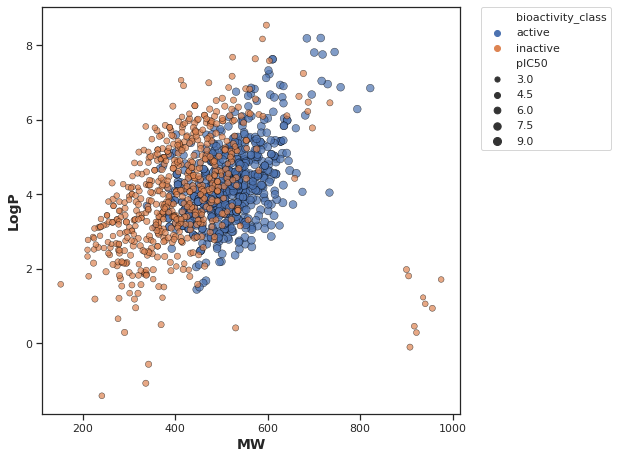

In [42]:
plt.figure(figsize=(7.5, 7.5))

sns.scatterplot(x='MW', y='LogP', data=df_combined, hue='bioactivity_class', size='pIC50', edgecolor='black', alpha=0.7)

plt.xlabel('MW', fontsize=14, fontweight='bold')
plt.ylabel('LogP', fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
plt.savefig('CHEMBL1957_IGF1R_plot_MW_vs_LogP.pdf')

### **Box plots &　Hypothesis Test**

#### **MW**

Text(0, 0.5, 'pIC50 value')

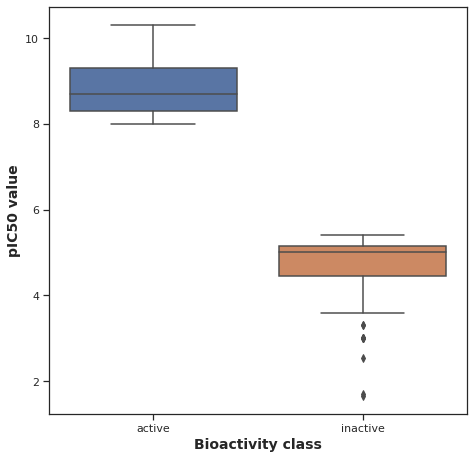

In [43]:
plt.figure(figsize=(7.5, 7.5))

sns.boxplot(x = 'bioactivity_class', y = 'pIC50', data = df_combined)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('pIC50 value', fontsize=14, fontweight='bold')

#plt.savefig('CHEMBL1957_IGF1R_plot_ic50.pdf')

In [44]:
mannwhitney('MW')

,Descriptor,Statistics,p,alpha,Interpretation
0,MW,55972.5,3.278040e-94,0.05,Different distribution (reject H0)


#### **LogP**

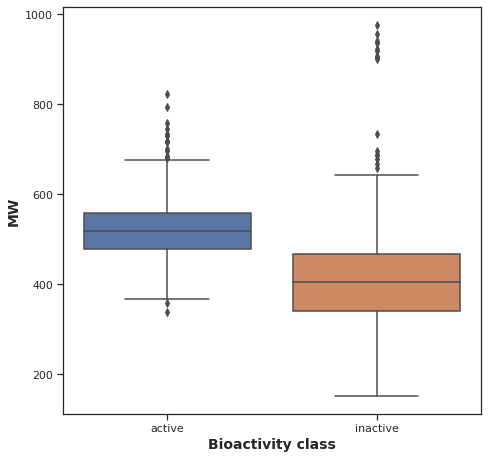

In [45]:
plt.figure(figsize=(7.5, 7.5))

sns.boxplot(x = 'bioactivity_class', y = 'MW', data = df_combined)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('MW', fontsize=14, fontweight='bold')

plt.savefig('CHEMBL1957_IGF1R_plot_MW.pdf')

#### **NumHDonors**

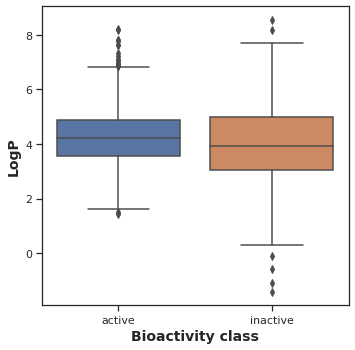

In [46]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'bioactivity_class', y = 'LogP', data = df_combined)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('LogP', fontsize=14, fontweight='bold')

plt.savefig('CHEMBL1957_IGF1R_plot_LogP.pdf')

In [47]:
mannwhitney('NumHDonors')

,Descriptor,Statistics,p,alpha,Interpretation
0,NumHDonors,146083.5,4.049720e-09,0.05,Different distribution (reject H0)


#### **NumHAcceptors**

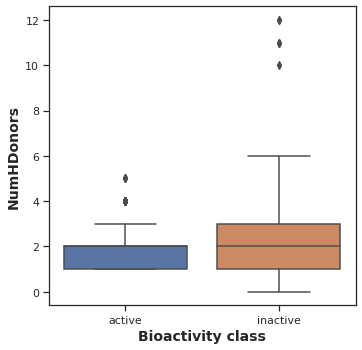

In [48]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'bioactivity_class', y = 'NumHDonors', data = df_combined)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('NumHDonors', fontsize=14, fontweight='bold')

plt.savefig('CHEMBL1957_IGF1R_plot_NumHDonors.pdf')

In [49]:
mannwhitney('NumHAcceptors')

,Descriptor,Statistics,p,alpha,Interpretation
0,NumHAcceptors,37151.5,3.182907e-127,0.05,Different distribution (reject H0)


# **Zip files**

In [50]:
! zip -r results.zip . -i *.csv *.pdf

  adding: CHEMBL1957_IGF1R_mannwhitneyu_NumHDonors.csv (deflated 11%)
  adding: CHEMBL1957_bioactivity_data_curated.csv (deflated 83%)
  adding: CHEMBL1957_IGF1R_mannwhitneyu_NumHAcceptors.csv (deflated 10%)
  adding: raw_CHEMBL1957_IGF1R.csv (deflated 90%)
  adding: CHEMBL1957_IGF1R_mannwhitneyu_MW.csv (deflated 8%)
  adding: CHEMBL1957_IGF1R_plot_LogP.pdf (deflated 38%)
  adding: CHEMBL1957_bioactivity_data_preprocessed.csv (deflated 82%)
  adding: CHEMBL1957_IGF1R_plot_MW.pdf (deflated 39%)
  adding: CHEMBL1957_2classes_lipinski_EDA_data.csv (deflated 79%)
  adding: CHEMBL1957_IGF1R_plot_MW_vs_LogP.pdf (deflated 4%)
  adding: CHEMBL1957_IGF1R_plot_NumHDonors.pdf (deflated 38%)
  adding: CHEMBL1957_2classes_data.csv (deflated 82%)


# **Calculate fingerprint descriptors**

## **Download PaDEL-Descriptor**

In [51]:
! wget http://www.yapcwsoft.com/dd/padeldescriptor/PaDEL-Descriptor.zip

--2021-04-08 18:21:50--  http://www.yapcwsoft.com/dd/padeldescriptor/PaDEL-Descriptor.zip
Resolving www.yapcwsoft.com (www.yapcwsoft.com)... 118.189.195.172
Connecting to www.yapcwsoft.com (www.yapcwsoft.com)|118.189.195.172|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20875190 (20M) [application/zip]
Saving to: ‘PaDEL-Descriptor.zip’

PaDEL-Descriptor.zi 100%[===================>]  19.91M  9.98MB/s    in 2.0s    

2021-04-08 18:21:52 (9.98 MB/s) - ‘PaDEL-Descriptor.zip’ saved [20875190/20875190]



In [52]:
! unzip PaDEL-Descriptor.zip

Archive:  PaDEL-Descriptor.zip
  inflating: Descriptors.xls         
  inflating: descriptors.xml         
   creating: lib/
  inflating: lib/ambit2-base-2.4.7-SNAPSHOT.jar  
  inflating: lib/ambit2-core-2.4.7-SNAPSHOT.jar  
  inflating: lib/ambit2-smarts-2.4.7-SNAPSHOT.jar  
  inflating: lib/appframework-1.0.3.jar  
  inflating: lib/cdk-1.4.15.jar      
  inflating: lib/commons-cli-1.2.jar  
  inflating: lib/guava-17.0.jar      
  inflating: lib/jama.jar            
  inflating: lib/jgrapht-0.6.0.jar   
  inflating: lib/l2fprod-common-all.jar  
  inflating: lib/libPaDEL-Descriptor.jar  
  inflating: lib/libPaDEL-Jobs.jar   
  inflating: lib/libPaDEL.jar        
  inflating: lib/swing-worker-1.1.jar  
  inflating: lib/vecmath1.2-1.14.jar  
  inflating: lib/xom-1.1.jar         
   creating: license/
  inflating: license/lgpl-2.1.txt    
  inflating: license/lgpl.license    
  inflating: license/LICENSE.txt     
  inflating: license/README - CDK    
  inflating: PaDEL-Descriptor.jar    


In [53]:
# Modify the descriptors.xml file for calculation
import lxml.etree

# input
doc = lxml.etree.parse('descriptors.xml')
# modification
for el in doc.xpath("//Descriptor[@name!='PubchemFingerprinter']"):
  el.attrib['value'] = 'false'
# output
# open('output_file.xml', 'w').write(lxml.etree.tostring(doc))
doc.write('pubchemfingerprinter.xml')

## **Load bioactivity data**

In [54]:
import pandas as pd

In [55]:
df = pd.read_csv('CHEMBL1957_2classes_lipinski_EDA_data.csv')
df.head()
print(df.shape)

(1196, 8)


In [56]:
selection = ['canonical_smiles','molecule_chembl_id']
df_selection = df[selection]
df_selection.to_csv('molecule.smi', sep='\t', index=False, header=False)

In [57]:
! cat molecule.smi | head -5

CN1CCN(CCn2ccc(Nc3ncc4c(n3)-c3c(nn(C)c3-c3ccc(-c5cnn(C)c5)cc3)CC4)n2)CC1	CHEMBL3905758
COc1cc(N2CCN(C(C)C)CC2)ccc1Nc1ncc2c(n1)-c1c(nn(C)c1-c1ccc(-c3cnn(C)c3)cc1)CC2	CHEMBL3950012
COc1cc(N2CCN(CCO)CC2)ccc1Nc1ncc2c(n1)-c1c(nn(C)c1-c1ccc(-c3cnn(C)c3)cc1)CC2	CHEMBL3955626
Cn1cc(-c2cccc(Cc3c4c(nn3C)CCc3cnc(Nc5ccn(CCCN6CCCC6)n5)nc3-4)c2)cn1	CHEMBL3928243
COc1cc(C(=O)NCCCN(C)C)ccc1Nc1ncc2c(n1)-c1c(nn(C)c1Cc1cccc(-c3cnn(C)c3)c1)CC2	CHEMBL3977170


In [58]:
! cat molecule.smi | wc -l

1196


## **Calculate PaDEL descriptors**

In [61]:
! java -Xms1G -Xmx1G -Djava.awt.headless=true -jar ./PaDEL-Descriptor.jar -removesalt -standardizenitro -fingerprints -descriptortypes ./pubchemfingerprinter.xml -dir ./ -file binary_descriptors_output.csv

Processing CHEMBL3905758 in molecule.smi (1/1196). 
Processing CHEMBL3950012 in molecule.smi (2/1196). 
Processing CHEMBL3955626 in molecule.smi (3/1196). Average speed: 7.86 s/mol.
Processing CHEMBL3928243 in molecule.smi (4/1196). Average speed: 4.22 s/mol.
Processing CHEMBL3977170 in molecule.smi (5/1196). Average speed: 3.41 s/mol.
Processing CHEMBL3979064 in molecule.smi (6/1196). Average speed: 2.59 s/mol.
Processing CHEMBL3979509 in molecule.smi (8/1196). Average speed: 2.05 s/mol.
Processing CHEMBL3896205 in molecule.smi (7/1196). Average speed: 2.39 s/mol.
Processing CHEMBL3969930 in molecule.smi (9/1196). Average speed: 2.24 s/mol.
Processing CHEMBL3916799 in molecule.smi (10/1196). Average speed: 1.75 s/mol.
Processing CHEMBL3892425 in molecule.smi (11/1196). Average speed: 1.66 s/mol.
Processing CHEMBL3893323 in molecule.smi (12/1196). Average speed: 1.52 s/mol.
Processing CHEMBL3952080 in molecule.smi (13/1196). Average speed: 1.46 s/mol.
Processing CHEMBL3985408 in molecu

In [62]:
! ls -l

total 111724
-rw-r--r-- 1 root root  2137437 Apr  8 18:28 binary_descriptors_output.csv
-rw-r--r-- 1 root root   114170 Apr  8 18:19 CHEMBL1957_2classes_data.csv
-rw-r--r-- 1 root root   166012 Apr  8 18:21 CHEMBL1957_2classes_lipinski_EDA_data.csv
-rw-r--r-- 1 root root   298398 Apr  8 18:19 CHEMBL1957_bioactivity_data_curated.csv
-rw-r--r-- 1 root root   239186 Apr  8 18:16 CHEMBL1957_bioactivity_data_preprocessed.csv
-rw-r--r-- 1 root root      121 Apr  8 18:21 CHEMBL1957_IGF1R_mannwhitneyu_MW.csv
-rw-r--r-- 1 root root      134 Apr  8 18:21 CHEMBL1957_IGF1R_mannwhitneyu_NumHAcceptors.csv
-rw-r--r-- 1 root root      130 Apr  8 18:21 CHEMBL1957_IGF1R_mannwhitneyu_NumHDonors.csv
-rw-r--r-- 1 root root    13806 Apr  8 18:21 CHEMBL1957_IGF1R_plot_LogP.pdf
-rw-r--r-- 1 root root    13561 Apr  8 18:21 CHEMBL1957_IGF1R_plot_MW.pdf
-rw-r--r-- 1 root root   221903 Apr  8 18:21 CHEMBL1957_IGF1R_plot_MW_vs_LogP.pdf
-rw-r--r-- 1 root root    14811 Apr  8 18:21 CHEMBL1957_IGF1R_plot_NumHDonors.p

# **Preparing the X and Y Data Matrices**

## **X data matrix**

In [64]:
df_X = pd.read_csv('binary_descriptors_output.csv')
print(df_X.shape)
df_X.head(5)

(1196, 882)


,Name,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,PubchemFP9,PubchemFP10,PubchemFP11,PubchemFP12,PubchemFP13,PubchemFP14,PubchemFP15,PubchemFP16,PubchemFP17,PubchemFP18,PubchemFP19,PubchemFP20,PubchemFP21,PubchemFP22,PubchemFP23,PubchemFP24,PubchemFP25,PubchemFP26,PubchemFP27,PubchemFP28,PubchemFP29,PubchemFP30,PubchemFP31,PubchemFP32,PubchemFP33,PubchemFP34,PubchemFP35,PubchemFP36,PubchemFP37,PubchemFP38,...,PubchemFP841,PubchemFP842,PubchemFP843,PubchemFP844,PubchemFP845,PubchemFP846,PubchemFP847,PubchemFP848,PubchemFP849,PubchemFP850,PubchemFP851,PubchemFP852,PubchemFP853,PubchemFP854,PubchemFP855,PubchemFP856,PubchemFP857,PubchemFP858,PubchemFP859,PubchemFP860,PubchemFP861,PubchemFP862,PubchemFP863,PubchemFP864,PubchemFP865,PubchemFP866,PubchemFP867,PubchemFP868,PubchemFP869,PubchemFP870,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880
0,CHEMBL3905758,1,1,1,1,0,0,0,0,0,1,1,1,1,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,CHEMBL3950012,1,1,1,1,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,CHEMBL3928243,1,1,1,1,0,0,0,0,0,1,1,1,1,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,CHEMBL3955626,1,1,1,1,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,CHEMBL3977170,1,1,1,1,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [65]:
df_X = df_X.drop(columns=['Name'])
print(df_X.shape)
df_X.head(3)

(1196, 881)


,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,PubchemFP9,PubchemFP10,PubchemFP11,PubchemFP12,PubchemFP13,PubchemFP14,PubchemFP15,PubchemFP16,PubchemFP17,PubchemFP18,PubchemFP19,PubchemFP20,PubchemFP21,PubchemFP22,PubchemFP23,PubchemFP24,PubchemFP25,PubchemFP26,PubchemFP27,PubchemFP28,PubchemFP29,PubchemFP30,PubchemFP31,PubchemFP32,PubchemFP33,PubchemFP34,PubchemFP35,PubchemFP36,PubchemFP37,PubchemFP38,PubchemFP39,...,PubchemFP841,PubchemFP842,PubchemFP843,PubchemFP844,PubchemFP845,PubchemFP846,PubchemFP847,PubchemFP848,PubchemFP849,PubchemFP850,PubchemFP851,PubchemFP852,PubchemFP853,PubchemFP854,PubchemFP855,PubchemFP856,PubchemFP857,PubchemFP858,PubchemFP859,PubchemFP860,PubchemFP861,PubchemFP862,PubchemFP863,PubchemFP864,PubchemFP865,PubchemFP866,PubchemFP867,PubchemFP868,PubchemFP869,PubchemFP870,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880
0,1,1,1,1,0,0,0,0,0,1,1,1,1,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,1,1,1,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,1,1,1,0,0,0,0,0,1,1,1,1,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## **Y variable**

In [66]:
df_Y = df['bioactivity_class']
df_Y.shape

(1196,)

## **Final dataset**

In [67]:
df_final = pd.concat([df_X,df_Y], axis=1)
print(df_final.shape)
df_final.head(3)

(1196, 882)


,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,PubchemFP9,PubchemFP10,PubchemFP11,PubchemFP12,PubchemFP13,PubchemFP14,PubchemFP15,PubchemFP16,PubchemFP17,PubchemFP18,PubchemFP19,PubchemFP20,PubchemFP21,PubchemFP22,PubchemFP23,PubchemFP24,PubchemFP25,PubchemFP26,PubchemFP27,PubchemFP28,PubchemFP29,PubchemFP30,PubchemFP31,PubchemFP32,PubchemFP33,PubchemFP34,PubchemFP35,PubchemFP36,PubchemFP37,PubchemFP38,PubchemFP39,...,PubchemFP842,PubchemFP843,PubchemFP844,PubchemFP845,PubchemFP846,PubchemFP847,PubchemFP848,PubchemFP849,PubchemFP850,PubchemFP851,PubchemFP852,PubchemFP853,PubchemFP854,PubchemFP855,PubchemFP856,PubchemFP857,PubchemFP858,PubchemFP859,PubchemFP860,PubchemFP861,PubchemFP862,PubchemFP863,PubchemFP864,PubchemFP865,PubchemFP866,PubchemFP867,PubchemFP868,PubchemFP869,PubchemFP870,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880,bioactivity_class
0,1,1,1,1,0,0,0,0,0,1,1,1,1,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,active
1,1,1,1,1,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,active
2,1,1,1,1,0,0,0,0,0,1,1,1,1,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,active


In [68]:
df_final.to_csv('CHEMBL1957_IGF1R_2class_pubchem_fp.csv', index=False)